In the second part of this study, we obtained temperature data for the United States, the United Kingdom, and Europe using R Studio. As Bluesky is a decentralized platform with limited official statistics on user distribution, we referenced estimates from multiple research institutions. Overall, approximately 31% of users are from the United States, 25% from Brazil, 8% from Spain, 4.5% from Canada, and 3.6% from the United Kingdom, indicating a high-quality and increasingly diverse user base (1).

Other data sources show that over 40% of Bluesky users are based in the United States, and about 21% are from English-speaking countries such as the United Kingdom and Canada (2). The platform currently has around 26 million users, with approximately 3.5 million daily active users from the United States and the United Kingdom combined (3). In terms of website traffic, the United States accounts for 52%, the United Kingdom for 8%, Japan for 6.6%, Brazil for 5%, and Canada for 3% (3). Another report states that monthly visitors are distributed as follows: 42.44% from the United States, 10.28% from Brazil, and 7.53% from the United Kingdom (4).

Due to the lack of detailed geolocation data, we selected temperature data from specific countries for separate analysis rather than weighting by user population. Since the study focuses on heatwave events during the Northern Hemisphere summers of 2023 and 2024 in the United Kingdom, countries in the Southern Hemisphere were excluded. Additionally, considering that the majority of content retrieved on Bluesky is in English, data from Asian countries were not included.

Specifically, we collected daily mean temperature data from representative GSN (Global Summary of the Day Network) stations across Europe (EU) and the United States (USA), as well as from 180 stations across the United Kingdom (UK). Due to the relatively small geographic area of the UK, GSN stations alone were insufficient for full representation, and additional local stations were incorporated. All data were sourced from the Global Historical Climatology Network (GHCN) maintained by the U.S. National Oceanic and Atmospheric Administration (NOAA) and retrieved using the rnoaa package within an R environment running on Google Colab.

The complete list of station IDs and metadata can be found in the "UK, European and USA temp data" folder of the project's GitHub repository. This folder contains both raw and processed daily mean temperature data for two periods: June 1 to September 30, 2023, and June 1 to September 30, 2024.

Temperature records were retrieved using the meteo_pull_monitors() function, extracting the variable "TAVG" (daily mean temperature). The original data, recorded in tenths of degrees Celsius, were converted to degrees Celsius (°C) by dividing by 10. Incomplete or missing records were removed during data cleaning.

The final dataset includes:

United States (USA): 7,597 valid records

Europe (EU): 10,944 valid records

United Kingdom (UK): 4,675 valid records

All data processing steps, including station selection, data retrieval, cleaning, and summarization, were conducted in R within a notebook environment, with full scripts available in the GitHub repository.

Links：
1.https://www.chaincatcher.com/en/article/2149675
2.https://www.lifewire.com/bluesky-vs-x-8777189
3.https://digitalmarketinginstitute.com/blog/what-is-bluesky-how-can-marketers-use-it
4.https://rootdigital.co.uk/blog/bluesky-statistics/

# Given the extensive length of the following code, the resulting figures generated in this file are displayed below!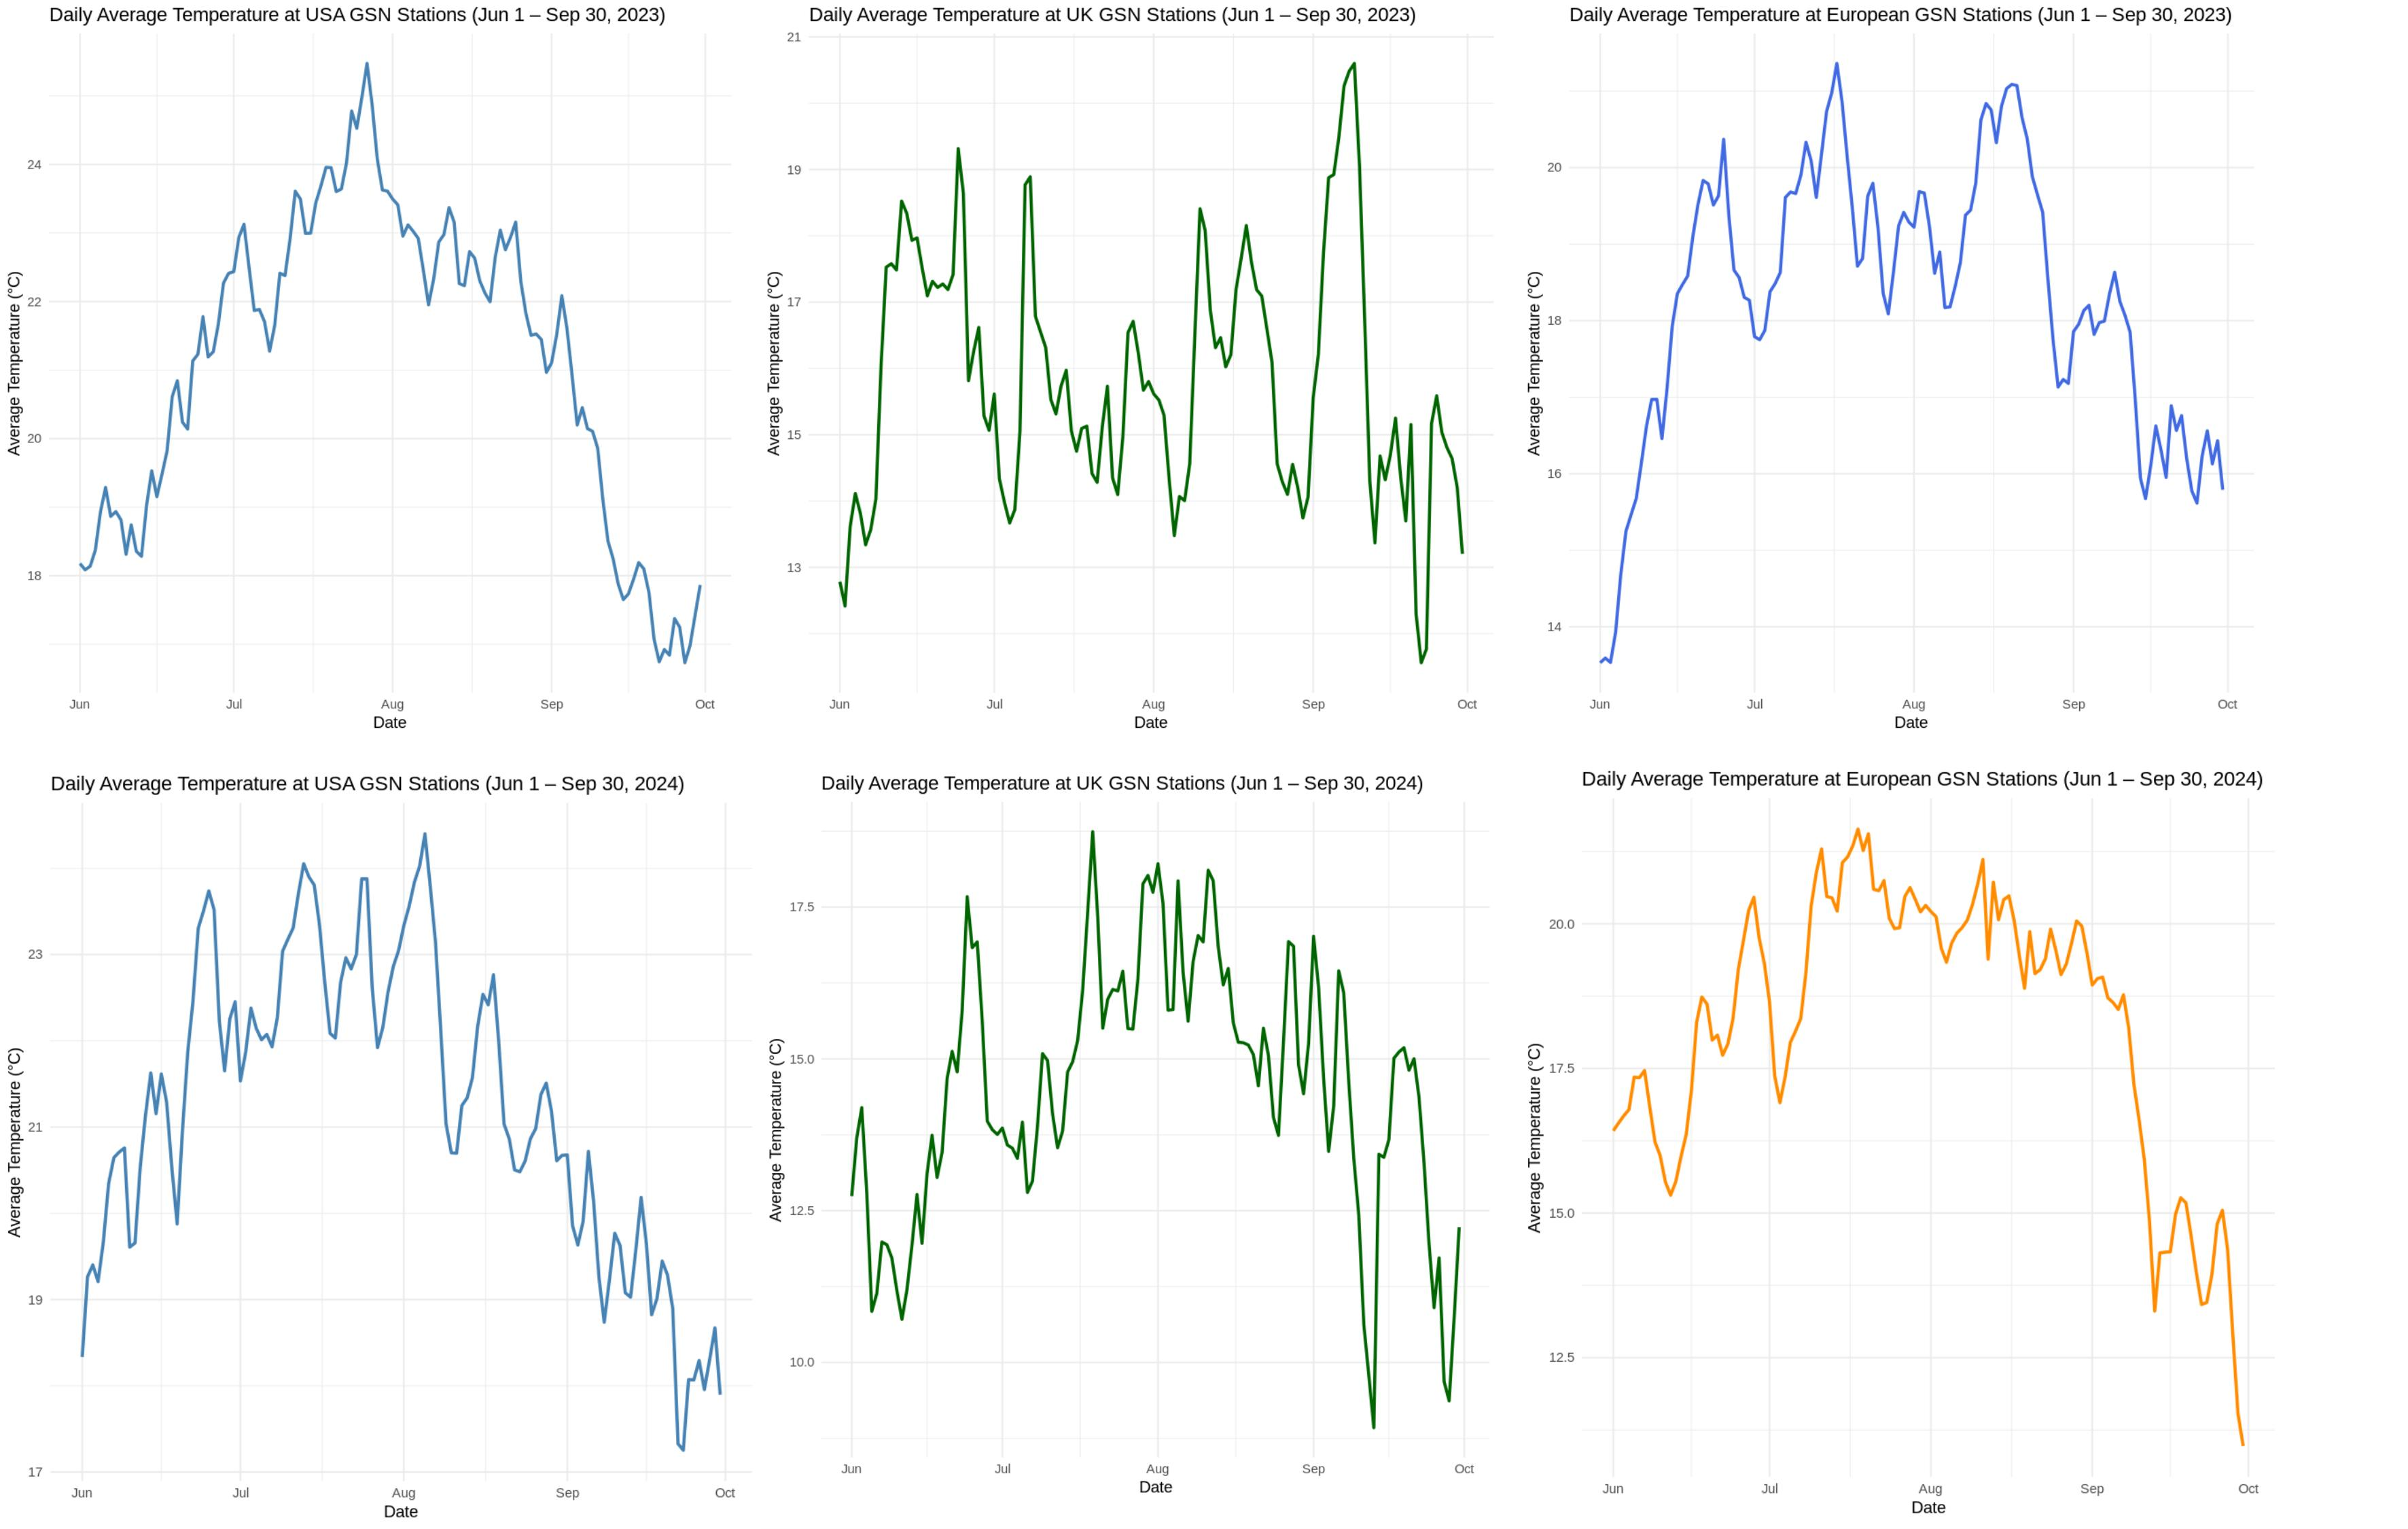

In [ ]:
install.packages("devtools")
install.packages("dplyr")
install.packages("readr")
install.packages("progress")
install.packages("purrr")

install.packages("devtools", repos = "https://cloud.r-project.org")
library(devtools)
devtools::install_github("ropensci/rnoaa")
library(rnoaa)

library(dplyr)
library(readr)
library(progress)
library(purrr)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




cli       (3.6.4 -> 3.6.5    ) [CRAN]
triebeard (NA    -> 0.4.1    ) [CRAN]
rjson     (NA    -> 0.2.23   ) [CRAN]
scales    (1.3.0 -> 1.4.0    ) [CRAN]
httpcode  (NA    -> 0.3.0    ) [CRAN]
urltools  (NA    -> 1.7.3    ) [CRAN]
hoardr    (NA    -> 0.5.5    ) [CRAN]
geonames  (NA    -> 0.999    ) [CRAN]
isdparser (NA    -> 0.4.0    ) [CRAN]
gridExtra (NA    -> 2.3      ) [CRAN]
XML       (NA    -> 3.99-0.18) [CRAN]
crul      (NA    -> 1.5.0    ) [CRAN]


Installing 12 packages: cli, triebeard, rjson, scales, httpcode, urltools, hoardr, geonames, isdparser, gridExtra, XML, crul

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpVMGpck/remotes19e1d37caef/ropensci-rnoaa-b26b4c5/DESCRIPTION’ ... OK
* preparing ‘rnoaa’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Removed empty directory ‘rnoaa/vignettes’
  NB: this package now depends on R (>= 4.1.0)
  pipe |> or function shorthand \(...) syntax added in R 4.1.0.
  File(s) using such syntax:
    ‘vis_miss.R’
* building ‘rnoaa_1.4.0.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

The rnoaa package will soon be retired and archived because the underlying APIs have changed dramatically. The package currently works but does not pull the most recent data in all cases. A noaaWeather package is planned as a replacement but the functions will not be interchangeable.


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
# Download the GHCN stations metadata file
url <- "https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"
download.file(url, destfile = "ghcnd-stations.txt", mode = "wb")

raw_lines <- readLines("ghcnd-stations.txt")

stations <- data.frame(
  id = substr(raw_lines, 1, 11),
  latitude = as.numeric(substr(raw_lines, 13, 20)),
  longitude = as.numeric(substr(raw_lines, 22, 30)),
  elevation = as.numeric(substr(raw_lines, 32, 37)),
  state = substr(raw_lines, 39, 40),
  name = trimws(substr(raw_lines, 42, 71)),
  gsn_flag = substr(raw_lines, 73, 75),
  hcn_flag = substr(raw_lines, 77, 79),
  wmo_id = substr(raw_lines, 81, 85),
  stringsAsFactors = FALSE
)
head(stations)

,id,latitude,longitude,elevation,state,name,gsn_flag,hcn_flag,wmo_id
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ACW00011604,17.1167,-61.7833,10.1,,ST JOHNS COOLIDGE FLD,,,
2,ACW00011647,17.1333,-61.7833,19.2,,ST JOHNS,,,
3,AE000041196,25.3330,55.5170,34.0,,SHARJAH INTER. AIRP,GSN,,41196
4,AEM00041194,25.2550,55.3640,10.4,,DUBAI INTL,,,41194
5,AEM00041217,24.4330,54.6510,26.8,,ABU DHABI INTL,,,41217
6,AEM00041218,24.2620,55.6090,264.9,,AL AIN INTL,,,41218


In [ ]:
usa_stations <- stations %>%
  filter(substr(id, 1, 2) == "US")
europe_stations <- stations %>%
  filter(latitude > 35 & latitude < 72 & longitude > -10 & longitude < 40)

library(rnoaa)

get_temp_data <- function(ids, region_name) {
  df <- meteo_pull_monitors(monitors = ids,
                            var = "TAVG",
                            date_min = "2023-06-01",
                            date_max = "2023-10-01")
  df$tavg <- df$tavg / 10
  df$region <- region_name
  return(df)
}

In [ ]:
usa_stations <- stations %>%
  filter(substr(id, 1, 2) == "US")

europe_stations <- stations %>%
  filter(latitude > 35 & latitude < 72 & longitude > -10 & longitude < 40)
get_temp_data <- function(ids, region_name) {
  df <- meteo_pull_monitors(monitors = ids,
                            var = "TAVG",
                            date_min = "2023-06-01",
                            date_max = "2023-10-01")
  df$tavg <- df$tavg / 10
  df$region <- region_name
  return(df)
}
get_station_temp <- function(id, region_name) {
  df <- meteo_pull_monitors(monitors = id,
                            var = "TAVG",
                            date_min = "2023-06-01",
                            date_max = "2023-10-01")
  df$tavg <- df$tavg / 10
  df$region <- region_name
  return(df)
}

usa_data <- get_station_temp("USW00094789", "USA")
europe_data <- get_station_temp("FR000007640", "Europe")


file min/max dates: 1948-07-01 / 2025-04-30

Warning message in meteo_pull_monitors(monitors = id, var = "TAVG", date_min = "2023-06-01", :
“The following stations could not be pulled from the GHCN ftp:
 FR000007640 
Any other monitors were successfully pulled from GHCN.”
Warning message:
“Unknown or uninitialised column: `tavg`.”


In [ ]:
# download GHCN STATION METADATA
url <- "https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"
download.file(url, destfile = "ghcnd-stations.txt", mode = "wb")
raw_lines <- readLines("ghcnd-stations.txt")

# dataframe STRUCTURE
stations <- data.frame(
  id = substr(raw_lines, 1, 11),
  latitude = as.numeric(substr(raw_lines, 13, 20)),
  longitude = as.numeric(substr(raw_lines, 22, 30)),
  elevation = as.numeric(substr(raw_lines, 32, 37)),
  state = substr(raw_lines, 39, 40),
  name = trimws(substr(raw_lines, 42, 71)),
  gsn_flag = substr(raw_lines, 73, 75),
  hcn_flag = substr(raw_lines, 77, 79),
  wmo_id = substr(raw_lines, 81, 85),
  stringsAsFactors = FALSE
)

In [ ]:
library(progress)
library(purrr)

get_multi_station_data <- function(id_list, region_label,
                                   var = "TAVG",
                                   date_min = "2023-06-01",
                                   date_max = "2023-10-01") {
  message(paste("ING", region_label, " ", length(id_list), ""))

  pb <- progress_bar$new(
    format = paste0(region_label, " PROCESS [:bar] :percent | FINISH: :current/:total"),
    total = length(id_list),
    clear = FALSE,
    width = 60
  )

  all_data <- purrr::map_dfr(id_list, function(station_id) {
    pb$tick()
    tryCatch({
      df <- meteo_pull_monitors(monitors = station_id,
                                var = var,
                                date_min = date_min,
                                date_max = date_max)
      df[[tolower(var)]] <- df[[tolower(var)]] /
      df$region <- region_label
      return(df)
    }, error = function(e) {
      return(NULL)
    })
  })

  return(all_data)
}

# 1.USA GSN station daily mean temperature download 2023


[1] 70

Fetching USA station data. Total: 70

using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/USP00CA0003.dly

date created (size, mb): 2025-04-25 11:54:05.936294 (0.015)

file min/max dates: 1863-01-01 / 1865-08-31

Warning message in meteo_pull_monitors(monitors = station_id, var = var, date_min = date_min, :
“The following stations could not be pulled from the GHCN ftp:
 USP00CA0003 
Any other monitors were successfully pulled from GHCN.”
using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/USW00003870.dly

date created (size, mb): 2025-04-25 11:54:15.084241 (7.596)

file min/max dates: 1962-10-01 / 2025-04-30

using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/USW00003945.dly

date created (size, mb): 2025-04-25 11:54:28.796661 (7.221)

file min/max dates: 1969-11-01 / 2025-04-30

using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/USW00012836.dly

date created (size, mb): 2025-04-25 11:54:43.296162 (7.417)

file min/max dates: 1948-01-01 / 2025-04-30

using cached file: /root/.cache/R/rno

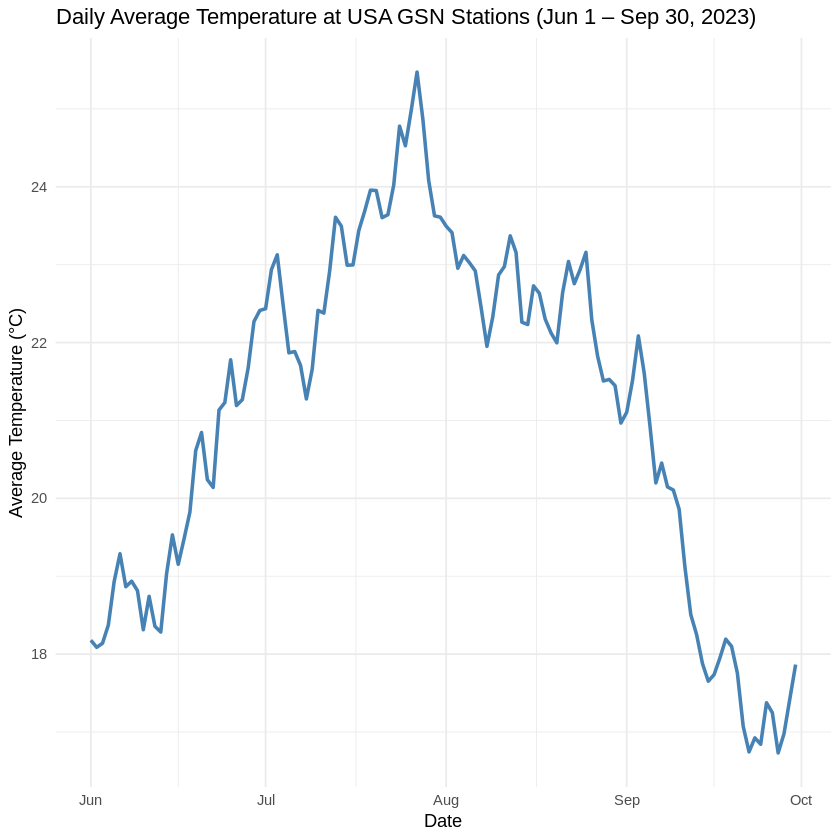

In [ ]:
# ==== Filter USA GSN stations ====
usa_gsn_ids <- stations %>%
  filter(substr(id, 1, 2) == "US", gsn_flag == "GSN") %>%
  pull(id)
length(usa_gsn_ids)

# ==== Define function: fetch TAVG data from multiple stations with progress bar ====
get_multi_station_data <- function(id_list, region_label,
                                   var = "TAVG",
                                   date_min = "2023-06-01",
                                   date_max = "2023-09-30") {
  message(paste("Fetching", region_label, "station data. Total:", length(id_list)))

  pb <- progress_bar$new(
    format = paste0(region_label, " Progress [:bar] :percent | Completed: :current/:total"),
    total = length(id_list),
    clear = FALSE,
    width = 60
  )

  all_data <- purrr::map_dfr(id_list, function(station_id) {
    pb$tick()
    tryCatch({
      df <- meteo_pull_monitors(monitors = station_id,
                                var = var,
                                date_min = date_min,
                                date_max = date_max)
      df[[tolower(var)]] <- df[[tolower(var)]] / 10  # Convert temp from tenths of °C to °C
      df$region <- region_label
      return(df)
    }, error = function(e) {
      return(NULL)
    })
  })

  return(all_data)
}

# ==== Fetch temperature data for USA GSN stations (June–September 2023) ====
usa_data <- get_multi_station_data(usa_gsn_ids, "USA",
                                   var = "TAVG",
                                   date_min = "2023-06-01",
                                   date_max = "2023-09-30")

write.csv(usa_data, "usa_temperature_gsn_2023.csv", row.names = FALSE)

# ==== Clean and summarize daily average temperature ====
usa_clean <- usa_data %>%
  filter(!is.na(tavg))

usa_avg_daily <- usa_clean %>%
  group_by(date) %>%
  summarise(avg_temp = mean(tavg)) %>%
  ungroup()

write.csv(usa_avg_daily, "usa_avg_temperature_2023_Jun-Sep.csv", row.names = FALSE)

# ==== Visualize daily average temperature trend ====
install.packages("ggplot2")
library(ggplot2)
ggplot(usa_avg_daily, aes(x = as.Date(date), y = avg_temp)) +
  geom_line(color = "steelblue", linewidth = 1) +
  labs(
    title = "Daily Average Temperature at USA GSN Stations (Jun 1 – Sep 30, 2023)",
    x = "Date", y = "Average Temperature (°C)"
  ) +
  theme_minimal()

# 2.USA GSN station daily mean temperature download 2024

Fetching USA station data. Total: 70

using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/USP00CA0003.dly

date created (size, mb): 2025-04-25 11:54:05.936294 (0.015)

file min/max dates: 1863-01-01 / 1865-08-31

Warning message in meteo_pull_monitors(monitors = station_id, var = var, date_min = date_min, :
“The following stations could not be pulled from the GHCN ftp:
 USP00CA0003 
Any other monitors were successfully pulled from GHCN.”
using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/USW00003870.dly

date created (size, mb): 2025-04-25 11:54:15.084241 (7.596)

file min/max dates: 1962-10-01 / 2025-04-30

using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/USW00003945.dly

date created (size, mb): 2025-04-25 11:54:28.796661 (7.221)

file min/max dates: 1969-11-01 / 2025-04-30

using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/USW00012836.dly

date created (size, mb): 2025-04-25 11:54:43.296162 (7.417)

file min/max dates: 1948-01-01 / 2025-04-30

using cached file: /root/.cache/R/rno

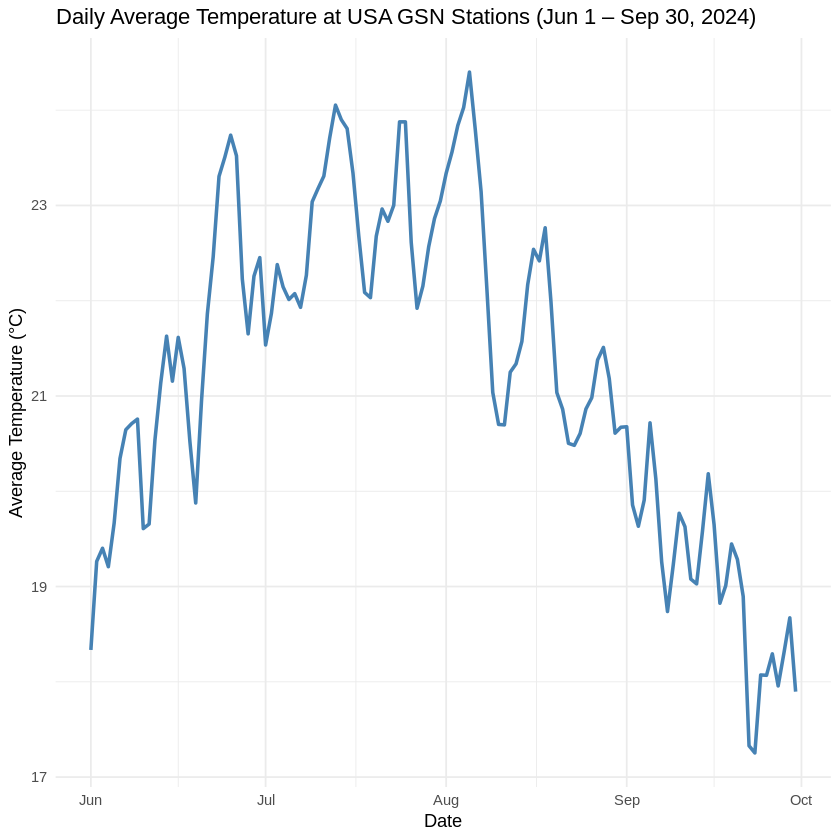

In [ ]:
get_multi_station_data <- function(id_list, region_label,
                                   var = "TAVG",
                                   date_min = "2024-06-01",
                                   date_max = "2024-09-30") {
  message(paste("Fetching", region_label, "station data. Total:", length(id_list)))

  pb <- progress_bar$new(
    format = paste0(region_label, " Progress [:bar] :percent | Completed: :current/:total"),
    total = length(id_list),
    clear = FALSE,
    width = 60
  )

  all_data <- purrr::map_dfr(id_list, function(station_id) {
    pb$tick()
    tryCatch({
      df <- meteo_pull_monitors(monitors = station_id,
                                var = var,
                                date_min = date_min,
                                date_max = date_max)
      df[[tolower(var)]] <- df[[tolower(var)]] / 10
      df$region <- region_label
      return(df)
    }, error = function(e) {
      return(NULL)
    })
  })

  return(all_data)
}

# ==== Fetch temperature data for USA GSN stations (June–September 2024) ====
usa_data <- get_multi_station_data(usa_gsn_ids, "USA",
                                   var = "TAVG",
                                   date_min = "2024-06-01",
                                   date_max = "2024-09-30")
write.csv(usa_data, "usa_temperature_gsn_2024.csv", row.names = FALSE)

# ==== Clean and summarize daily average temperature ====
usa_clean <- usa_data %>%
  filter(!is.na(tavg))
usa_avg_daily <- usa_clean %>%
  group_by(date) %>%
  summarise(avg_temp = mean(tavg)) %>%
  ungroup()
write.csv(usa_avg_daily, "usa_avg_temperature_2024_Jun-Sep.csv", row.names = FALSE)

ggplot(usa_avg_daily, aes(x = as.Date(date), y = avg_temp)) +
  geom_line(color = "steelblue", linewidth = 1) +
  labs(
    title = "Daily Average Temperature at USA GSN Stations (Jun 1 – Sep 30, 2024)",
    x = "Date", y = "Average Temperature (°C)"
  ) +
  theme_minimal()

# 3.UK GSN station daily mean temperature download 2023

[1] 180

Fetching UK station data. Total: 180

using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/EI000003953.dly

date created (size, mb): 2025-04-25 12:34:45.014839 (2.035)

file min/max dates: 1929-10-01 / 2025-04-30

file min/max dates: 1954-10-01 / 2009-11-30

file min/max dates: 1867-01-01 / 2025-04-30

using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/EI000003980.dly

date created (size, mb): 2025-04-25 12:34:49.970352 (2.179)

file min/max dates: 1885-01-01 / 2025-02-28

file min/max dates: 1861-01-01 / 2002-12-31

Warning message in meteo_pull_monitors(monitors = station_id, var = var, date_min = date_min, :
“The following stations could not be pulled from the GHCN ftp:
 EIE00101859 
Any other monitors were successfully pulled from GHCN.”
file min/max dates: 1941-01-01 / 2024-11-30

Warning message in meteo_pull_monitors(monitors = station_id, var = var, date_min = date_min, :
“The following stations could not be pulled from the GHCN ftp:
 EIE00107762 
Any other monitors were successf

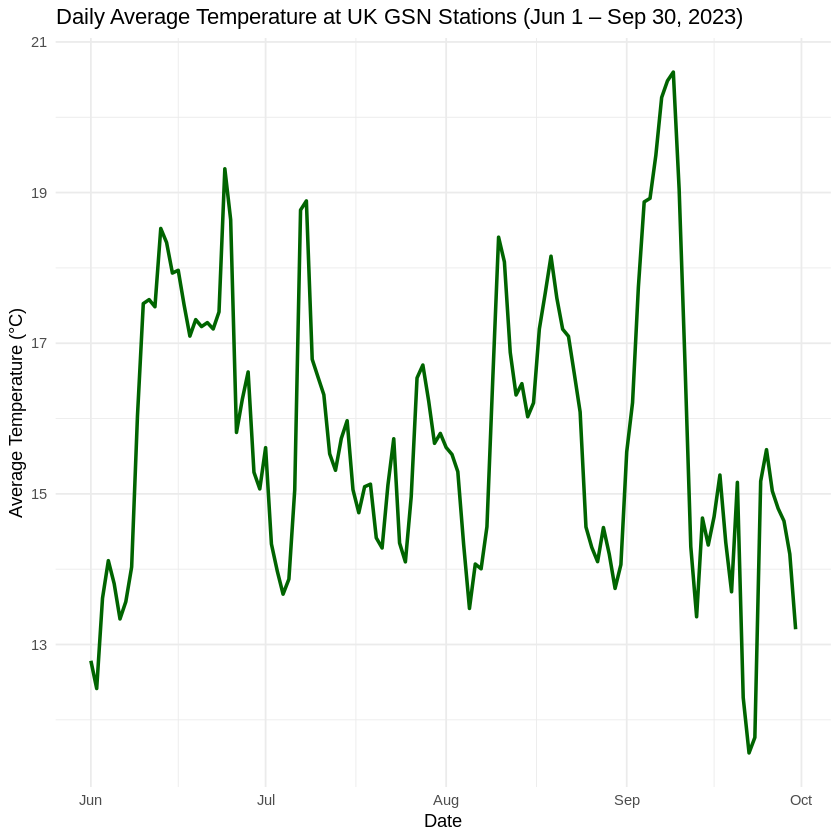

In [ ]:
#Filter UK stations based on geographic bounds
uk_ids <- stations %>%
  filter(latitude > 49, latitude < 61,
         longitude > -11, longitude < 2) %>%
  pull(id)

length(uk_ids)

uk_data <- get_multi_station_data(uk_ids, "UK",
                                  var = "TAVG",
                                  date_min = "2023-06-01",
                                  date_max = "2023-09-30")

write.csv(uk_data, "uk_temperature_gsn_2023.csv", row.names = FALSE)

uk_clean <- uk_data %>%
  filter(!is.na(tavg))

uk_avg_daily <- uk_clean %>%
  group_by(date) %>%
  summarise(avg_temp = mean(tavg)) %>%
  ungroup()

write.csv(uk_avg_daily, "uk_avg_temperature_2023_Jun-Sep.csv", row.names = FALSE)

ggplot(uk_avg_daily, aes(x = as.Date(date), y = avg_temp)) +
  geom_line(color = "darkgreen", linewidth = 1) +
  labs(
    title = "Daily Average Temperature at UK GSN Stations (Jun 1 – Sep 30, 2023)",
    x = "Date", y = "Average Temperature (°C)"
  ) +
  theme_minimal()

# 4.UK GSN station daily mean temperature download 2024

[1] 180

Fetching UK station data. Total: 180

using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/EI000003953.dly

date created (size, mb): 2025-04-25 12:34:45.014839 (2.035)

file min/max dates: 1929-10-01 / 2025-04-30

using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/EI000003965.dly

date created (size, mb): 2025-04-25 12:37:00.930913 (1.236)

file min/max dates: 1954-10-01 / 2009-11-30

using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/EI000003969.dly

date created (size, mb): 2025-04-25 12:37:05.936431 (3.176)

file min/max dates: 1867-01-01 / 2025-04-30

using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/EI000003980.dly

date created (size, mb): 2025-04-25 12:34:49.970352 (2.179)

file min/max dates: 1885-01-01 / 2025-02-28

using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/EIE00101859.dly

date created (size, mb): 2025-04-25 12:37:12.483109 (1.932)

file min/max dates: 1861-01-01 / 2002-12-31

Warning message in meteo_pull_monitors(monitors = station_id, var = var, date_min = date_min

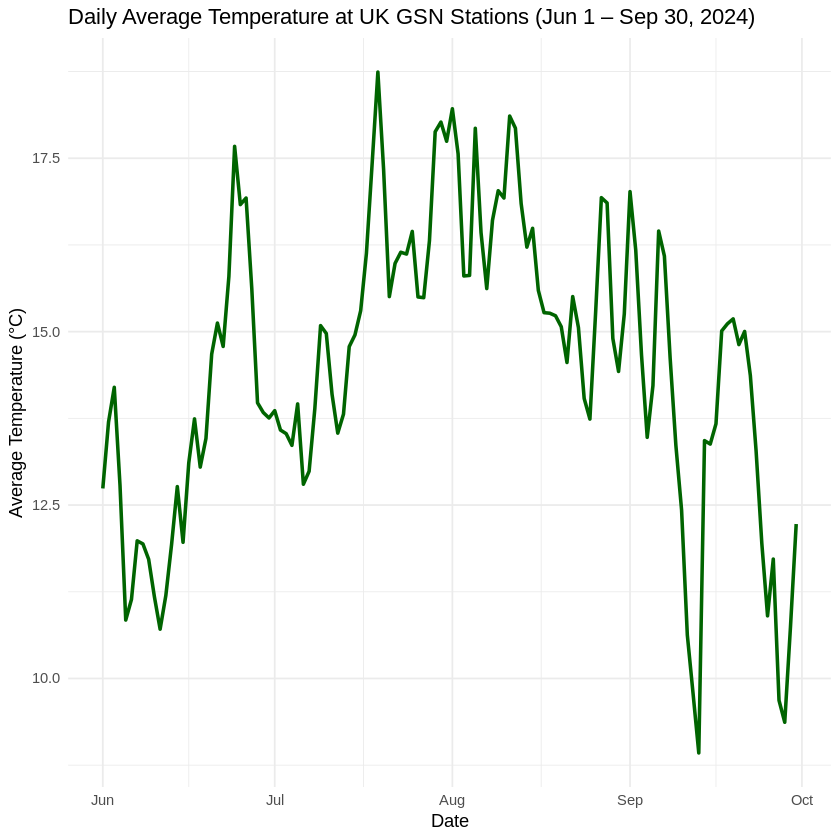

In [ ]:
#Filter UK stations based on geographic bounds
uk_ids <- stations %>%
  filter(latitude > 49, latitude < 61,
         longitude > -11, longitude < 2) %>%
  pull(id)

length(uk_ids)

uk_data <- get_multi_station_data(uk_ids, "UK",
                                  var = "TAVG",
                                  date_min = "2024-06-01",
                                  date_max = "2024-09-30")

write.csv(uk_data, "uk_temperature_gsn_2024.csv", row.names = FALSE)

uk_clean <- uk_data %>%
  filter(!is.na(tavg))

uk_avg_daily <- uk_clean %>%
  group_by(date) %>%
  summarise(avg_temp = mean(tavg)) %>%
  ungroup()

write.csv(uk_avg_daily, "uk_avg_temperature_2024_Jun-Sep.csv", row.names = FALSE)

ggplot(uk_avg_daily, aes(x = as.Date(date), y = avg_temp)) +
  geom_line(color = "darkgreen", linewidth = 1) +
  labs(
    title = "Daily Average Temperature at UK GSN Stations (Jun 1 – Sep 30, 2024)",
    x = "Date", y = "Average Temperature (°C)"
  ) +
  theme_minimal()

# 5.European GSN station daily mean temperature download 2023

[1] 102

Fetching Europe station data. Total: 102

file min/max dates: 1940-01-01 / 2025-04-30

file min/max dates: 1973-02-01 / 2025-04-30

file min/max dates: 1876-01-01 / 2025-04-30

file min/max dates: 1855-02-01 / 2025-04-30

file min/max dates: 1886-11-01 / 2024-04-30

file min/max dates: 1833-01-01 / 2025-04-30

file min/max dates: 1897-10-01 / 2025-03-31

file min/max dates: 1881-01-01 / 2025-04-30

file min/max dates: 1873-12-01 / 2000-12-31

Warning message in meteo_pull_monitors(monitors = station_id, var = var, date_min = date_min, :
“The following stations could not be pulled from the GHCN ftp:
 DA000030380 
Any other monitors were successfully pulled from GHCN.”
file min/max dates: 1973-01-01 / 2021-05-31

using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/EI000003980.dly

date created (size, mb): 2025-04-25 12:34:49.970352 (2.179)

file min/max dates: 1885-01-01 / 2025-02-28

file min/max dates: 1901-01-01 / 2025-04-30

file min/max dates: 1906-05-01 / 2025-04-30

file min/max da

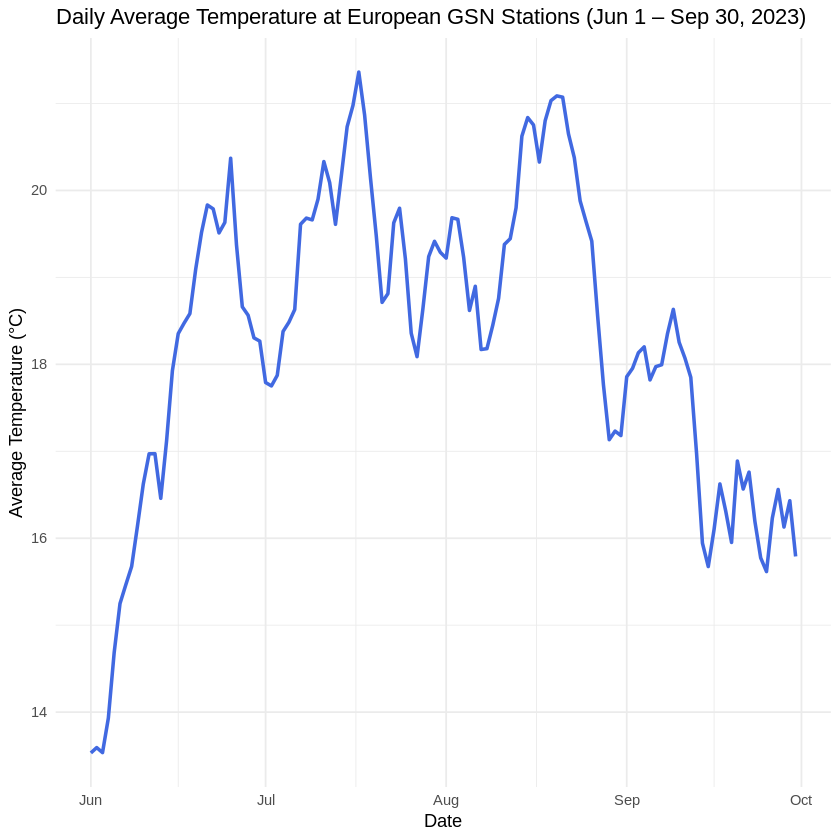

In [ ]:
# ==== Filter European GSN stations ====
europe_gsn_ids <- stations %>%
  filter(latitude > 35, latitude < 72,
         longitude > -10, longitude < 40,
         gsn_flag == "GSN") %>%
  pull(id)

length(europe_gsn_ids)
get_multi_station_data <- function(id_list, region_label,
                                   var = "TAVG",
                                   date_min = "2023-06-01",
                                   date_max = "2023-09-30") {
  message(paste("Fetching", region_label, "station data. Total:", length(id_list)))

  pb <- progress_bar$new(
    format = paste0(region_label, " Progress [:bar] :percent | Completed: :current/:total"),
    total = length(id_list),
    clear = FALSE,
    width = 60
  )

  all_data <- purrr::map_dfr(id_list, function(station_id) {
    pb$tick()
    tryCatch({
      df <- meteo_pull_monitors(monitors = station_id,
                                var = var,
                                date_min = date_min,
                                date_max = date_max)
      df[[tolower(var)]] <- df[[tolower(var)]] / 10  # Convert from tenths °C to °C
      df$region <- region_label
      return(df)
    }, error = function(e) {
      return(NULL)
    })
  })

  return(all_data)
}

europe_data <- get_multi_station_data(europe_gsn_ids, "Europe",
                                      var = "TAVG",
                                      date_min = "2023-06-01",
                                      date_max = "2023-09-30")

write.csv(europe_data, "europe_temperature_gsn_2023.csv", row.names = FALSE)
europe_clean <- europe_data %>%
  filter(!is.na(tavg))

europe_avg_daily <- europe_clean %>%
  group_by(date) %>%
  summarise(avg_temp = mean(tavg)) %>%
  ungroup()

write.csv(europe_avg_daily, "europe_avg_temperature_2023_Jun-Sep.csv", row.names = FALSE)

library(ggplot2)

ggplot(europe_avg_daily, aes(x = as.Date(date), y = avg_temp)) +
  geom_line(color = "royalblue", linewidth = 1) +
  labs(
    title = "Daily Average Temperature at European GSN Stations (Jun 1 – Sep 30, 2023)",
    x = "Date", y = "Average Temperature (°C)"
  ) +
  theme_minimal()


# 6.European GSN station daily mean temperature download 2024

Fetching Europe station data. Total: 102

using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/AG000060390.dly

date created (size, mb): 2025-04-25 12:48:52.242566 (1.911)

file min/max dates: 1940-01-01 / 2025-04-30

using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/ALM00013615.dly

date created (size, mb): 2025-04-25 12:48:54.441793 (0.628)

file min/max dates: 1973-02-01 / 2025-04-30

using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/AU000005010.dly

date created (size, mb): 2025-04-25 12:49:00.023371 (3.076)

file min/max dates: 1876-01-01 / 2025-04-30

using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/AU000005901.dly

date created (size, mb): 2025-04-25 12:49:07.547151 (3.703)

file min/max dates: 1855-02-01 / 2025-04-30

using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/AU000015410.dly

date created (size, mb): 2025-04-25 12:49:15.410965 (3.308)

file min/max dates: 1886-11-01 / 2024-04-30

using cached file: /root/.cache/R/rnoaa/noaa_ghcnd/BE000006447.dly

date created (size, 

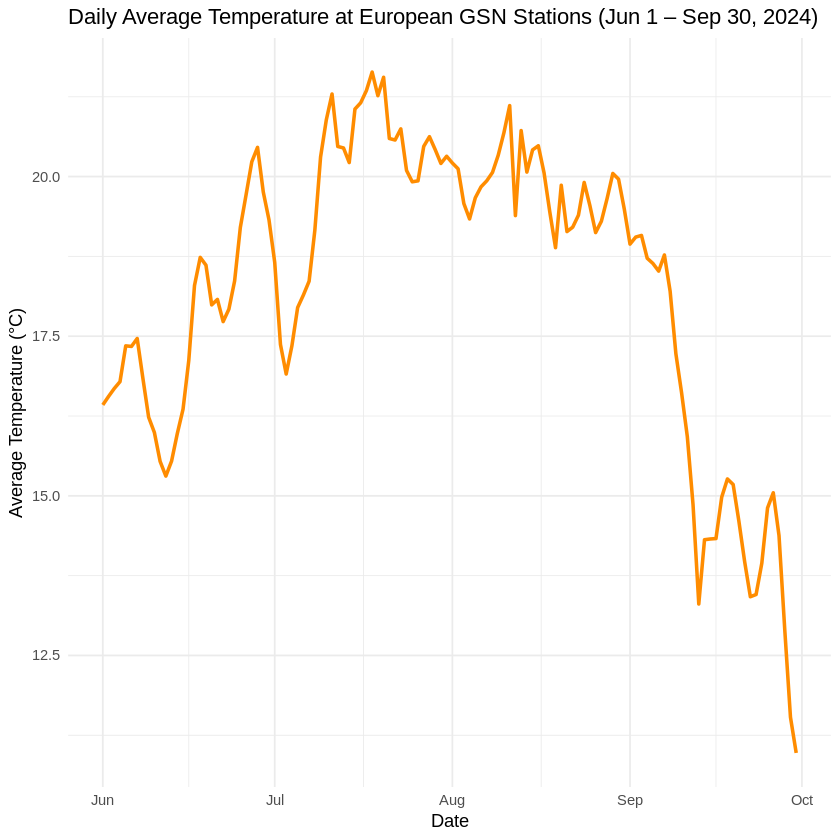

In [ ]:
europe_data_2024 <- get_multi_station_data(europe_gsn_ids, "Europe",
                                           var = "TAVG",
                                           date_min = "2024-06-01",
                                           date_max = "2024-09-30")

write.csv(europe_data_2024, "europe_temperature_gsn_2024.csv", row.names = FALSE)

europe_clean_2024 <- europe_data_2024 %>%
  filter(!is.na(tavg))

europe_avg_daily_2024 <- europe_clean_2024 %>%
  group_by(date) %>%
  summarise(avg_temp = mean(tavg)) %>%
  ungroup()

write.csv(europe_avg_daily_2024, "europe_avg_temperature_2024_Jun-Sep.csv", row.names = FALSE)

ggplot(europe_avg_daily_2024, aes(x = as.Date(date), y = avg_temp)) +
  geom_line(color = "darkorange", linewidth = 1) +
  labs(
    title = "Daily Average Temperature at European GSN Stations (Jun 1 – Sep 30, 2024)",
    x = "Date", y = "Average Temperature (°C)"
  ) +
  theme_minimal()